<img src='assets/svhn_dcgan.png' width=80% />

# Deep Convolutional GANs

training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset.

In [1]:
# import all the packages:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle as pkl

%matplotlib inline


In [4]:
from torchvision import datasets
from torchvision import transforms


#convert to pytorch tensors
transforms = transforms.ToTensor()

#SVHN training datasets
shvn_train_datasets =datasets.SVHN(root='data/' ,
                                   split='train',
                                   download =True,
                                   transform= transforms)

batch_size = 64
num_workers= 0

# bulid Dataloader for SHVN datasets

train_loader = torch.utils.data.DataLoader(dataset =shvn_train_datasets,
                                      batch_size = batch_size,
                                      shuffle = True,
                                      num_workers = num_workers)





Using downloaded and verified file: data/train_32x32.mat


# Visualize the Data
Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has one associated, numerical label.

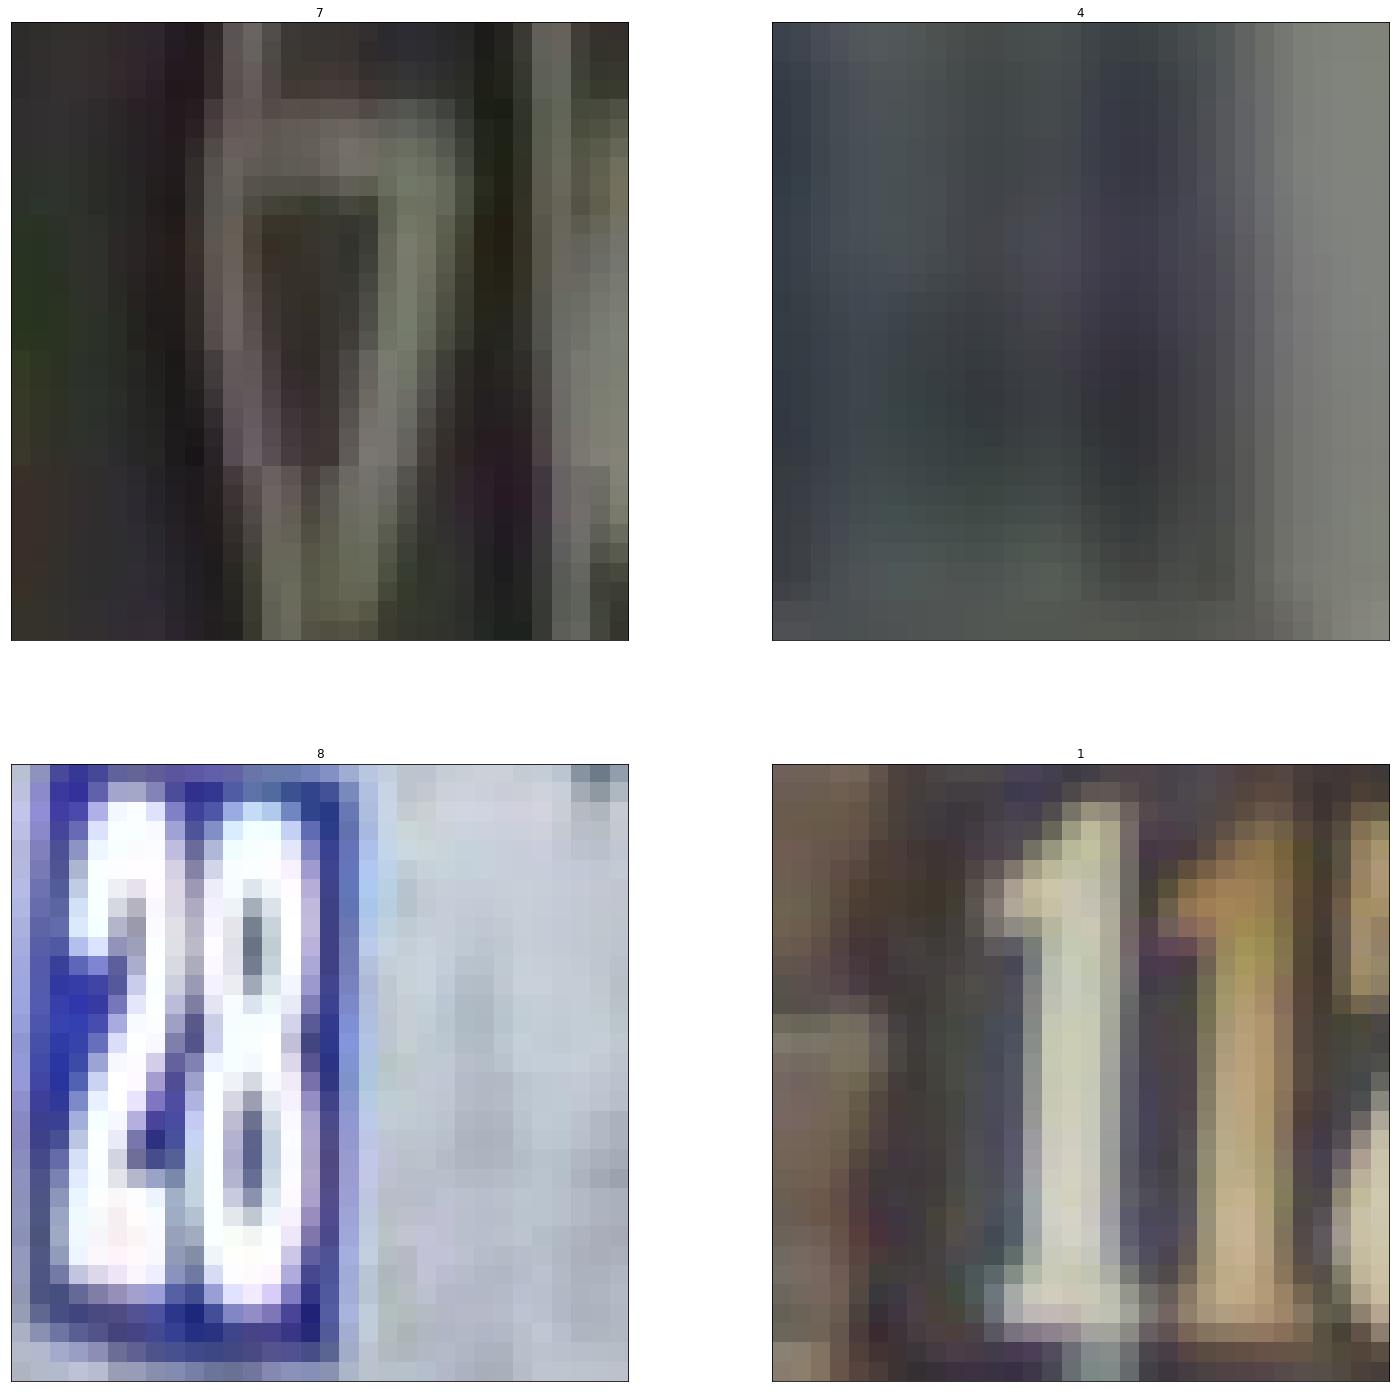

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


fig= plt.figure(figsize =(25, 25))

plot_size = 4
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

# pre- processing the input between -1 , 1


In [34]:
img = images[0]

print(img.min())
print(img.max())

tensor(0.0706)
tensor(0.5216)


In [38]:
def scale(image , feature_range=(-1 ,1)):
    min, max = feature_range
    image = image * (max - min) + min
    return image



In [39]:
scaled_img = scale(images[0])

print(scaled_img.min())
print(scaled_img.max())

tensor(-0.8588)
tensor(0.0431)


# Define the Model


## Discriminator

<img src='assets/conv_discriminator.png' width=80%/>

In [53]:
import torch.nn as nn
import torch.nn.functional as F


def conv(in_channels , out_channels , kernel_size ,
         stride=2 , padding = 1 , batch_norm = True):
    
    layers = []
    convolution_layer= nn.Conv2d(in_channels,
                                 out_channels,
                                 kernel_size,
                                 stride,
                                 padding,
                                 bias = False)
    layers.append(convolution_layer)
    if batch_norm :
        layers.append(nn.BatchNorm2d(out_channels)) 
    return nn.Sequential(*layers)



class Discriminator(nn.Module):
    
    def __init__(self, conv_dim = 32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        
        self.conv1 = conv(3, conv_dim , 4 , batch_norm = False)
        
        self.conv2 = conv(conv_dim ,conv_dim*2 ,4 , batch_norm= True)
        
        self.conv3 = conv(conv_dim*2,conv_dim*4,4 , batch_norm= True)
        
        self.fc1   = nn.Linear(conv_dim*4*4*4 , 1)
        
        
    def forward(self , image):
        
        x = F.leaky_relu(self.conv1(image) ,0.2)
        x = F.leaky_relu(self.conv2(x) ,0.2)
        x = F.leaky_relu(self.conv3(x) ,0.2)
        
        flat = x.view(-1 , self.conv_dim*4*4*4)
        logits = self.fc1(flat)
        
        
        return logits
        
        
    
        
        

## Generator

<img src='assets/conv_generator.png' width=80% />


In [72]:
def deconv(in_channels,out_channels, kernel_size,
           stride = 2, padding= 1,batch_norm = True ):
    
    layers = []
    conv_transpose = nn.ConvTranspose2d(in_channels,
                                        out_channels,
                                        kernel_size,
                                        padding,
                                        bias = False)
    layers.append(conv_transpose)  
    
    if batch_norm :
        layers.append(nn.BatchNorm2d(out_channels))
        
    
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim = 32):
        super(Generator , self).__init__()
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
    
    
    def forward(self,image):
        out = self.fc(image)
        out = out.view(-1 , self.conv_dim*4 ,4 , 4)
        
        
        out = F.leaky_relu(self.t_conv1(out) , 0.2)
        out = F.leaky_relu(self.t_conv2(out) , 0.2)
        out = F.leaky_relu(self.t_conv3(out) , 0.2)
        
        final = F.tanh(out)
        
        return final 
        
        
        
        
    

In [73]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
disc = Discriminator(conv_dim)
gene = Generator(z_size=z_size, conv_dim=conv_dim)

print(disc)
print("--------------------------------------------------------------")
print(gene)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)
--------------------------------------------------------------
Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_s

# `Discriminator and Generator Losses

In [101]:
def real_loss(d_output , smooth= False):
    batch_size =d_output.size(0)
    
    
    if smooth :
        labels = torch.ones(batch_size)*0.9
        
    else :
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(d_output.squeeze() , labels)
    #print("loss",loss)
    return loss
    
    
    
def fake_loss(d_output):
    batch_size = d_output.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    
    loss = criterion(d_output.squeeze(), labels)
    
    return loss
    
        

### Optimizers

### Hyperparameters

In [102]:
import torch.optim as optim 

# params

lr = 0.0002
beta1 = 0.5
beta2 = 0.999


d_optimizer = optim.Adam(disc.parameters() , 
                         lr , 
                         [beta1,beta2])
g_optimizer = optim.Adam(gene.parameters() ,
                         lr , 
                         [beta1,beta2])




## Training

In [103]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    
    
    
import pickle as pkl

num_epochs = 1

samples = []
losses  = []

print_every = 300
sample_size = 16
fixed_z = np.random.uniform(-1, 1,
                            size =(sample_size,z_size))

fixed_z = torch.from_numpy(fixed_z).float()



# train the network

for epoch in range(num_epochs):
    
    for batch_size_i , (real_images, _ ) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        real_images = scale(real_images)
        #print(real_images[0].min())
        #print(real_images[0].max())
        #print(type(real_images))
        
        
        d_optimizer.zero_grad()
        
        if train_on_gpu:
            real_images = real_images.cuda()
        d_real = disc(real_images)
        d_real_loss = real_loss(d_real)
        
        
        
        z = np.random.uniform(-1, 1 , size=(batch_size,z_size))
        
        z = torch.from_numpy(z).float()
        
        
        if train_on_gpu:
            z = z.cuda()
        
        fake_images = gene(z)
        
        
        d_fake = disc(fake_images)
        
        d_fake_loss = fake_loss(d_fake)
        #print(d_fake_loss)
        
        
        d_loss = d_real_loss + d_fake_loss
        #print("final disc loss" , d_loss)
        
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #-------generator training -----------#
        
        
        g_optimizer.zero_grad()
        
        
        z = np.random.uniform(-1, 1 , size=(batch_size , z_size))
        z = torch.from_numpy(z).float()
        
        if train_on_gpu:
            z = z.cuda()
            
        fake_images = gene(z)
        
        d_fake      = disc(fake_images)
        
        g_loss      = real_loss(d_fake)
        g_loss.backward()
        g_optimizer.step()
        
        
        if batch_size_i % print_every == 0 :
            
            losses.append((d_loss.item(), g_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format( epoch+1,num_epochs,d_loss.item(),g_loss.item()))
              
            
             
    gene.eval()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    samples_z = gene(fixed_z)
    samples.append(samples_z)
    gene.train()
    
        
            
            
        
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        


Training on CPU.
Epoch [    1/    1] | d_loss: 0.0622 | g_loss: 3.3452


KeyboardInterrupt: 

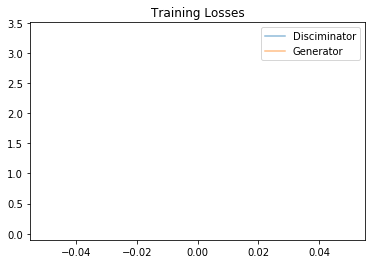

In [106]:
fig , ax = plt.subplots()

losses = np.array(losses)

plt.plot(losses.T[0] , label = 'Disciminator' , alpha=0.5)
plt.plot(losses.T[1] , label = 'Generator'    , alpha=0.5)
plt.title("Training Losses")
plt.legend()



In [107]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))